#**Deep Learning CNN Project Description**

#Deep Learning CNNs have multiple usages in Image Classification, in this project we attempt working on an Open Source Chest X-Ray Images from Kaggle to diagnose / classify Chest X-Rays as either Normal or Pneumonia. Initially, we started with a simpler Baseline Model which would be later used for comparison between two Transfer Learning models, a VGG19 Modified model and CoroNet model which is a modification of Xception. Results show that CoroNet had the best results based on selected performance metrics.

**Compiled List of References:**

1) https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia

2) Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow, 2nd Edition

3) A.I. Khan, J.L. Shah and M.M. Bhat / Computer Methods and Programs in Biomedicine 196 (2020) 105581

4) A Survey on Explainable Artificial Intelligence (XAI): towards Medical XAI, Erico Tjoa, and Cuntai Guan, Fellow, IEEE, VOL. 14, NO. 8, AUGUST 2015

5) Deep Convolutional Neural Networks for Chest Diseases Detection, Journal of Healthcare Engineering, Rahib H. Abiyev and Mohammad Khaleel Sallam Ma’aitah, 2018

6) Automated abnormality classification of chest radiographs using deep convolutional neural networks, Y.-X. Tang et al., 2020

7) X-Ray Image based COVID-19 Detection using Pre-trained Deep Learning Models, Subrata Chakraborty et al. 

8) https://medium.com/google-developer-experts/interpreting-deep-learning-models-for-computer-vision-f95683e23c1d

9) https://towardsdatascience.com/visualizing-intermediate-activation-in-convolutional-neural-networks-with-keras-260b36d60d0

10) https://github.com/gabrielpierobon/cnnshapes/blob/master/README.md

11) https://www.pyimagesearch.com/2019/10/14/why-is-my-validation-loss-lower-than-my-training-loss/

#Importing the Data

In [ ]:
# Mounting the gdrive to access the Chest X-Ray Images
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


#Preparing the Data

In [ ]:
# Importing libraries
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
# Adding the train/val/test splits in their respective directories, theen rescaling and resizing the Images to the appropriate pixels

train_dir = "/gdrive/MyDrive/Colab Notebooks/output2/train"
val_dir = "/gdrive/MyDrive/Colab Notebooks/output2/val"
test_dir = "/gdrive/MyDrive/Colab Notebooks/output2/test"

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

batchsize=128

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 224x224
        target_size=(224, 224),
        batch_size =3500,
        class_mode='binary')

val_generator = val_datagen.flow_from_directory(
        val_dir,
        target_size=(224, 224),
        batch_size=1170,
        class_mode='binary')

test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(224, 224),
        batch_size=1170,
        class_mode='binary')


X_train, y_train = next(train_generator)
X_val, y_val = next(val_generator)
X_test, y_test = next(test_generator)

Found 3522 images belonging to 2 classes.
Found 1170 images belonging to 2 classes.
Found 1174 images belonging to 2 classes.


In [ ]:
# Checking data shape
for data_batch, labels_batch in train_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

data batch shape: (22, 224, 224, 3)
labels batch shape: (22,)


In [ ]:
# Checking for the data classes
train_generator.class_indices

{'NORMAL': 0, 'PNEUMONIA': 1}

In [ ]:
# Importing appropriate libraries to apply the Deep Learning Models
import warnings
warnings.filterwarnings("ignore")

from IPython.display import Image
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import numpy as np
import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import auc


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D, Conv2D, MaxPooling2D
from keras.regularizers import L1L2


import vis
from keras import models, layers
from keras import optimizers
from keras.applications.vgg16 import preprocess_input, decode_predictions
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras import applications
from keras.preprocessing import image
from keras import backend as K
from keras.callbacks import EarlyStopping
from keras.wrappers.scikit_learn import KerasClassifier

#**Baseline Model 1**

#The first Baseline model is a simpler model containing one hidden layer and one output layer as shown below. Hyperparameter Tuning was performed on **regularization terms which affects feature importance, momentum, min_delta & patience which is sensitive to changes in the output metric affecting at which epoch to stop, learning rate affecting the rate of optimization, rate of decay for learning rate, as well as the choice of optimization technique**. As we have an unbalanced dataset, we selected the metrics accordingly to be True Positive, True Negative, False Positive, False Negative, Precision, Recall and AUC. Confusion Metrics are also implemented for better output visuals.

In [ ]:
# Setting the input dimension, regularization terms (L1L2) for selecting the important weights,
# initializer that corresponds to the appropriate activation function, early stopping if certain performance conditions are not met
# selecting the metrics accordingly since we have an unbalanced dataset

input=(224,224,3)
reg = L1L2(l1=0.01, l2=0.01)
initializer = 'HeNormal'
es = EarlyStopping(monitor='AUC', min_delta=0.03, patience=3, verbose=0, restore_best_weights=False)
loss='binary_crossentropy',
optimizer = 'Adam'
metrics = [
    keras.metrics.FalseNegatives(name="fn"),
    keras.metrics.FalsePositives(name="fp"),
    keras.metrics.TrueNegatives(name="tn"),
    keras.metrics.TruePositives(name="tp"),
    keras.metrics.Precision(name="precision"),
    keras.metrics.Recall(name="recall"),
    keras.metrics.AUC(name="AUC")]

# [keras.metrics.PrecisionAtRecall(recall=0.8)]  
#sgd = keras.optimizers.SGD(lr=0.05, decay=1e-6, momentum=0.9 , nesterov=True)  

In [ ]:
# Building the Baseline Model
model_1 = models.Sequential()
model_1.add(layers.Dense(2, activation='relu', kernel_initializer=initializer, kernel_regularizer=reg, input_shape=input)),
model_1.add(layers.Flatten()),
model_1.add(layers.Dense(1, activation='sigmoid'))

In [ ]:
# Compiling the model loss (objective function), optimizer and the metrics to calculate
model_1.compile(loss=loss,
                optimizer=optimizer,
                metrics=metrics)

In [ ]:
# Checking the model architecture
model_1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 224, 224, 2)       8         
_________________________________________________________________
flatten (Flatten)            (None, 100352)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 100353    
Total params: 100,361
Trainable params: 100,361
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Fitting the model to the training and validating on the validation data
history = model_1.fit(X_train, y_train, batch_size = batchsize, epochs=10, validation_data=(X_val, y_val))

Epoch 1/10
28/28 [==============================] - 11s 302ms/step - loss: 2.9517 - fn: 231.0690 - fp: 300.3793 - tn: 210.6897 - tp: 1167.6552 - precision: 0.7852 - recall: 0.8486 - AUC: 0.5918 - val_loss: 0.3355 - val_fn: 36.0000 - val_fp: 86.0000 - val_tn: 230.0000 - val_tp: 818.0000 - val_precision: 0.9049 - val_recall: 0.9578 - val_AUC: 0.9483
Epoch 2/10
28/28 [==============================] - 7s 247ms/step - loss: 0.4101 - fn: 108.7931 - fp: 120.4828 - tn: 405.2414 - tp: 1275.2759 - precision: 0.9096 - recall: 0.9182 - AUC: 0.9247 - val_loss: 0.2513 - val_fn: 19.0000 - val_fp: 64.0000 - val_tn: 252.0000 - val_tp: 835.0000 - val_precision: 0.9288 - val_recall: 0.9778 - val_AUC: 0.9754
Epoch 3/10
28/28 [==============================] - 7s 247ms/step - loss: 0.2897 - fn: 67.7586 - fp: 100.3448 - tn: 419.3103 - tp: 1322.3793 - precision: 0.9242 - recall: 0.9535 - AUC: 0.9628 - val_loss: 0.2178 - val_fn: 38.0000 - val_fp: 31.0000 - val_tn: 285.0000 - val_tp: 816.0000 - val_precision:

In [ ]:
# Prediction and Confusion Matrix of Test set
y_pred = model_1.predict_classes(X_test)#.ravel()
confusion_matrix = sklearn.metrics.confusion_matrix(y_test, np.rint(y_pred))

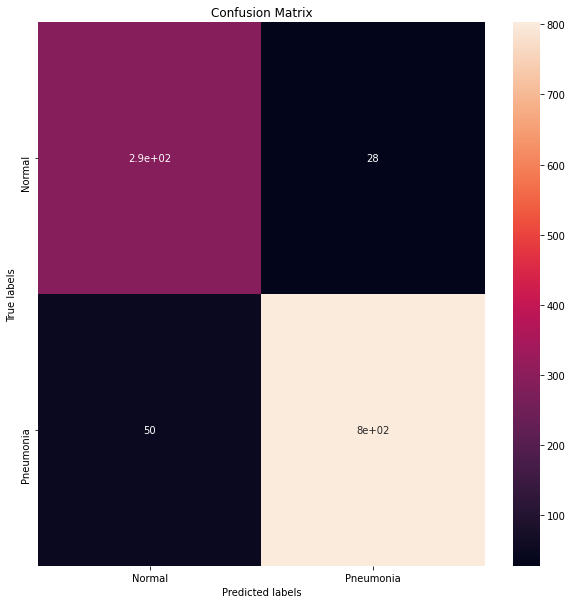

In [ ]:
# Confusion Matrix to show TN (top left), FP (top right), FN (bottom left), TP (bottom right)
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(confusion_matrix, annot=True, ax = ax) #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels') 
ax.set_title('Confusion Matrix') 
ax.xaxis.set_ticklabels(['Normal', 'Pneumonia']); ax.yaxis.set_ticklabels(['Normal', 'Pneumonia'])
plt.show()

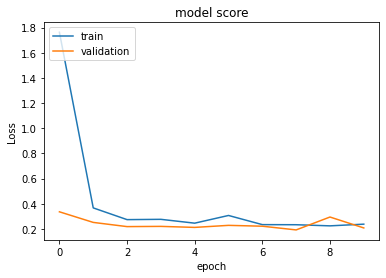

In [ ]:
# Plotting the Training and Validation Loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model score')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

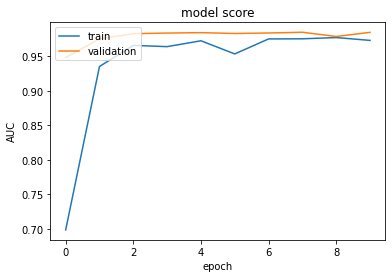

In [ ]:
# Plotting the Training and Validation AUC
plt.plot(history.history['AUC'])
plt.plot(history.history['val_AUC'])
plt.title('model score')
plt.ylabel('AUC')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

#**Model 2**
# Transfer Learning using VGG19 Model, based on this paper **(A.I. Khan, J.L. Shah and M.M. Bhat / Computer Methods and Programs in Biomedicine 196 (2020) 105581)** it appears that VGG19 is state of the art with Chest X-Ray Binary Classification Problems.

#The following Model implements the VGG19 architecture with modified Fully Connected Layers that include SELU activation in the hidden layers with the right initialization of LeCun Normal. As well a Flatten and Dropout layers are also added.

In [ ]:
# Pre-trained VGG19 model without fully connected layers
image_w, image_h = 224, 224
model_2 = applications.VGG19(weights = "imagenet", include_top=False, input_shape = (image_w, image_h, 3))
model_2.summary()

80142336/80134624 [==============================] - 1s 0us/step
Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
______________________________________________________________

In [ ]:
# Freezing all the VGG19 layers
for layer in model_2.layers[0:]:
    layer.trainable = False

In [ ]:
# Making sure all layers are Frozen
for i, layer in enumerate(model_2.layers):
    print(i, layer.name, layer.trainable)

0 input_1 False
1 block1_conv1 False
2 block1_conv2 False
3 block1_pool False
4 block2_conv1 False
5 block2_conv2 False
6 block2_pool False
7 block3_conv1 False
8 block3_conv2 False
9 block3_conv3 False
10 block3_conv4 False
11 block3_pool False
12 block4_conv1 False
13 block4_conv2 False
14 block4_conv3 False
15 block4_conv4 False
16 block4_pool False
17 block5_conv1 False
18 block5_conv2 False
19 block5_conv3 False
20 block5_conv4 False
21 block5_pool False


In [ ]:
# Adding the Fully Connected Layers to the VGG19 Model
new_model = Sequential([
    model_2,
    Flatten(name='flatten'),
    Dense(1024, activation='selu', kernel_initializer = 'LecunNormal', name='new_fc'),
    Dropout(0.5),
    Dense(256, activation='selu', kernel_initializer = 'LecunNormal', name='new_fc2'),
    Dense(1, activation='sigmoid', name='new_predictions')
])
new_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 7, 7, 512)         20024384  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
new_fc (Dense)               (None, 1024)              25691136  
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
new_fc2 (Dense)              (None, 256)               262400    
_________________________________________________________________
new_predictions (Dense)      (None, 1)                 257       
Total params: 45,978,177
Trainable params: 25,953,793
Non-trainable params: 20,024,384
_________________________________

In [ ]:
#Setting an early stopping criteria with a minimum change of the monitored value 
#that qualifies as an improvement as 0.03 and the number of epochs with no improvement at which training is stopped to be 3

es = EarlyStopping(monitor='AUC', min_delta=0.03, patience=3, verbose=0, restore_best_weights=True)

In [ ]:
# Compiling the model loss (objective function), optimizer and the metrics to calculate
new_model.compile(loss=keras.losses.binary_crossentropy,
              optimizer=keras.optimizers.Adam(learning_rate=0.001),
              metrics=metrics)

In [ ]:
# Fitting the model to the training and validating on the validation data
history = new_model.fit(X_train, y_train, batch_size=batchsize, epochs=10 , verbose=1, validation_data=(X_val,y_val), callbacks=[es])

Epoch 1/10
28/28 [==============================] - 2893s 104s/step - loss: 4.8950 - fn: 381.4483 - fp: 327.6207 - tn: 491.9310 - tp: 1878.7931 - precision: 0.8618 - recall: 0.8376 - AUC: 0.7410 - val_loss: 0.2519 - val_fn: 18.0000 - val_fp: 106.0000 - val_tn: 210.0000 - val_tp: 836.0000 - val_precision: 0.8875 - val_recall: 0.9789 - val_AUC: 0.9652
Epoch 2/10
28/28 [==============================] - 2892s 104s/step - loss: 0.3229 - fn: 118.0000 - fp: 114.6897 - tn: 399.8966 - tp: 1277.2069 - precision: 0.9122 - recall: 0.9161 - AUC: 0.9370 - val_loss: 0.1745 - val_fn: 49.0000 - val_fp: 39.0000 - val_tn: 277.0000 - val_tp: 805.0000 - val_precision: 0.9538 - val_recall: 0.9426 - val_AUC: 0.9781
Epoch 3/10
28/28 [==============================] - 2893s 104s/step - loss: 0.2280 - fn: 82.2069 - fp: 78.8621 - tn: 444.3103 - tp: 1304.4138 - precision: 0.9426 - recall: 0.9374 - AUC: 0.9606 - val_loss: 0.1449 - val_fn: 19.0000 - val_fp: 41.0000 - val_tn: 275.0000 - val_tp: 835.0000 - val_preci

In [ ]:
# Prediction and Confusion Matrix of Test set
y_pred_2 = new_model.predict_classes(X_test)#.ravel()
confusion_matrix = sklearn.metrics.confusion_matrix(y_test, np.rint(y_pred_2))

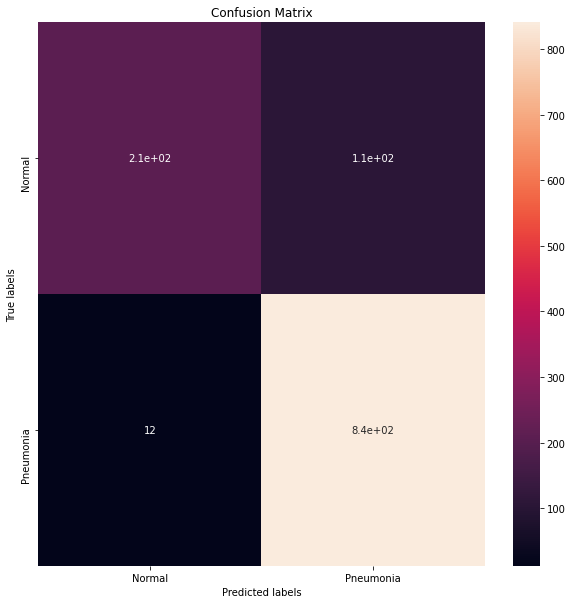

In [ ]:
# Confusion Matrix to show TN (top left), FP (top right), FN (bottom left), TP (bottom right)
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(confusion_matrix, annot=True, ax = ax) #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels') 
ax.set_title('Confusion Matrix') 
ax.xaxis.set_ticklabels(['Normal', 'Pneumonia']); ax.yaxis.set_ticklabels(['Normal', 'Pneumonia'])
plt.show()

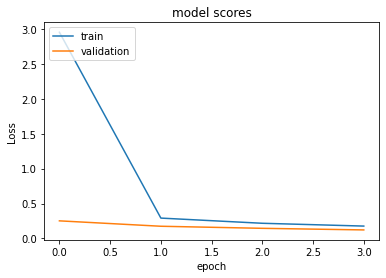

In [ ]:
# Plotting the Training and Validation Loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model scores')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

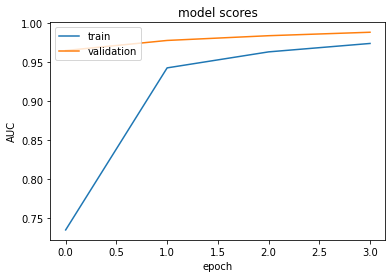

In [ ]:
# Plotting the Training and Validation AUC
plt.plot(history.history['AUC'])
plt.plot(history.history['val_AUC'])
plt.title('model scores')
plt.ylabel('AUC')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
#score = new_model.evaluate(X_test, y_test, verbose=0)
#print('Test loss:', score[0])
#print('Test accuracy:', score[1])

#**Model 3** - Attempting a proposed CoroNet architecture model mentioned in the paper **(A.I. Khan, J.L. Shah and M.M. Bhat / Computer Methods and Programs in Biomedicine 196 (2020) 105581)** as it got very high performance results with Binary Chest X-Ray Data.

#The model is based on the Xception model with some modifications to the output Fully Connected layers, it includes a Flatten, Dropout and a Dense layer with 256 neurons and RELU activation, accompanied by it's proper initializer HeNormal.

In [ ]:
# Pre-trained Xception model without fully connected layers
image_w, image_h = 224, 224
model_3 = applications.Xception(weights = "imagenet", include_top=False, input_shape = (image_w, image_h, 3))
model_3.summary()

83689472/83683744 [==============================] - 1s 0us/step
Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 111, 111, 32) 864         input_6[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 111, 111, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 111, 111, 32) 0           block1_conv1_bn[0][0]            
__________________________

In [ ]:
# Freezing all the Xception layers
for layer in model_3.layers[0:]:
    layer.trainable = False

In [ ]:
# Making sure all layers are Frozen
for i, layer in enumerate(model_3.layers):
    print(i, layer.name, layer.trainable)

0 input_6 False
1 block1_conv1 False
2 block1_conv1_bn False
3 block1_conv1_act False
4 block1_conv2 False
5 block1_conv2_bn False
6 block1_conv2_act False
7 block2_sepconv1 False
8 block2_sepconv1_bn False
9 block2_sepconv2_act False
10 block2_sepconv2 False
11 block2_sepconv2_bn False
12 conv2d False
13 block2_pool False
14 batch_normalization False
15 add False
16 block3_sepconv1_act False
17 block3_sepconv1 False
18 block3_sepconv1_bn False
19 block3_sepconv2_act False
20 block3_sepconv2 False
21 block3_sepconv2_bn False
22 conv2d_1 False
23 block3_pool False
24 batch_normalization_1 False
25 add_1 False
26 block4_sepconv1_act False
27 block4_sepconv1 False
28 block4_sepconv1_bn False
29 block4_sepconv2_act False
30 block4_sepconv2 False
31 block4_sepconv2_bn False
32 conv2d_2 False
33 block4_pool False
34 batch_normalization_2 False
35 add_2 False
36 block5_sepconv1_act False
37 block5_sepconv1 False
38 block5_sepconv1_bn False
39 block5_sepconv2_act False
40 block5_sepconv2 False

In [ ]:
# Adding the Fully Connected Layers to the CoroNet Model
new_model2 = Sequential([
    model_3,
    Flatten(name='flatten'),
    Dropout(0.5),
    Dense(256, activation='relu', kernel_initializer = 'HeNormal', name='new_fc'),
    Dense(1, activation='sigmoid', name='new_predictions')
])
new_model2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 7, 7, 2048)        20861480  
_________________________________________________________________
flatten (Flatten)            (None, 100352)            0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 100352)            0         
_________________________________________________________________
new_fc (Dense)               (None, 256)               25690368  
_________________________________________________________________
new_predictions (Dense)      (None, 1)                 257       
Total params: 46,552,105
Trainable params: 25,690,625
Non-trainable params: 20,861,480
_________________________________________________________________


In [ ]:
#Setting an early stopping criteria with a minimum change of the monitored value 
#that qualifies as an improvement as 0.03 and the number of epochs with no improvement at which training is stopped to be 3

es = EarlyStopping(monitor='AUC', min_delta=0.03, patience=3, verbose=0, restore_best_weights=True)

In [ ]:
# Compiling the model loss (objective function), optimizer and the metrics to calculate
new_model2.compile(loss=keras.losses.binary_crossentropy,
              optimizer=keras.optimizers.Adam(learning_rate=0.001),
              metrics=metrics)

In [ ]:
# Fitting the model to the training and validating on the validation data
history = new_model2.fit(X_train, y_train, batch_size=batchsize, epochs=10 , verbose=1, validation_data=(X_val,y_val), callbacks=[es])

Epoch 1/10
28/28 [==============================] - 887s 32s/step - loss: 8.2892 - fn: 412.5517 - fp: 195.0345 - tn: 639.4138 - tp: 1832.7931 - precision: 0.9022 - recall: 0.8277 - AUC: 0.8537 - val_loss: 0.1605 - val_fn: 35.0000 - val_fp: 35.0000 - val_tn: 281.0000 - val_tp: 819.0000 - val_precision: 0.9590 - val_recall: 0.9590 - val_AUC: 0.9791
Epoch 2/10
28/28 [==============================] - 880s 32s/step - loss: 0.1556 - fn: 45.2759 - fp: 55.6552 - tn: 457.7931 - tp: 1351.0690 - precision: 0.9587 - recall: 0.9690 - AUC: 0.9782 - val_loss: 0.1312 - val_fn: 9.0000 - val_fp: 46.0000 - val_tn: 270.0000 - val_tp: 845.0000 - val_precision: 0.9484 - val_recall: 0.9895 - val_AUC: 0.9903
Epoch 3/10
28/28 [==============================] - 891s 32s/step - loss: 0.1409 - fn: 30.8276 - fp: 57.5517 - tn: 466.7931 - tp: 1354.6207 - precision: 0.9534 - recall: 0.9806 - AUC: 0.9845 - val_loss: 0.1099 - val_fn: 34.0000 - val_fp: 17.0000 - val_tn: 299.0000 - val_tp: 820.0000 - val_precision: 0.97

In [ ]:
# Prediction and Confusion Matrix of Test set
y_pred_3 = new_model2.predict_classes(X_test)#.ravel()
confusion_matrix = sklearn.metrics.confusion_matrix(y_test, np.rint(y_pred_3))

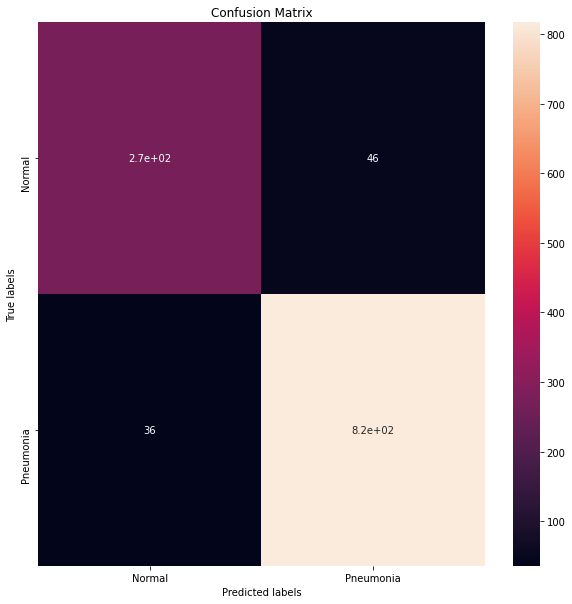

In [ ]:
# Confusion Matrix to show TN (top left), FP (top right), FN (bottom left), TP (bottom right)
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(confusion_matrix, annot=True, ax = ax) #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels') 
ax.set_title('Confusion Matrix') 
ax.xaxis.set_ticklabels(['Normal', 'Pneumonia']); ax.yaxis.set_ticklabels(['Normal', 'Pneumonia'])
plt.show()

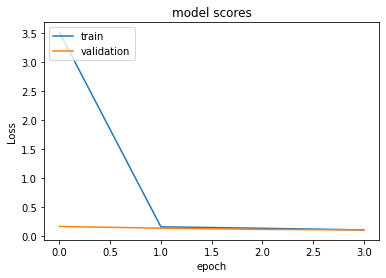

In [ ]:
# Plotting the Training and Validation Loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model scores')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

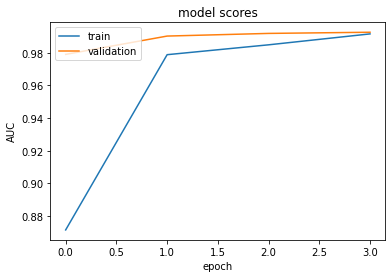

In [ ]:
# Plotting the Training and Validation AUC
plt.plot(history.history['AUC'])
plt.plot(history.history['val_AUC'])
plt.title('model scores')
plt.ylabel('AUC')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

#**Evaluating Models**

The following table and plots present the results of the three models.

Due to the unbalanced nature of the data, the above Confusion Matrix, and the below results in the table were chosen to be Precision, Recall, Specificity, F1 measure and Accuracy. 

Based on the below results, **Model 1** has a much higher number of False Negatives, explaining the lower Recall score, which could be very critical for the patients being falsely stated as 'Normal'. 

**Model 2** has a much higher number of False Positives which could be very costly for the organization as patients falsely stated as 'Pneumonia' might need further tests, that is why a low Specificity score was obtained. Model 2 also has the highest computational cost, it can be used if the organization is looking for an extremely high Recall to reduce the number of False Negatives, it will be costly on the other hand in terms of low Precision, Specificity and cost on the organization.

**Model 3** has a lower number of False Negatives than Model 1, and slightly higher False Postives. It also has a much lower FP than Model 2. Thus, Model 3 strikes a good balance of computational cost and results of FP and FN.

In [ ]:
# Plotting a Table of Model Results for comparison

import plotly.graph_objects as go

headerColor = 'grey'
rowEvenColor = 'lightgrey'
rowOddColor = 'white'

fig = go.Figure(data=[go.Table(
  header=dict(
    values=['<b>Model #</b>','<b>TN</b>','<b>TP</b>','<b>FN</b>','<b>FP</b>','<b>Precision</b>','<b>Recall</b>','<b>Specificity</b>','<b>F1 measure</b>','<b>Accuracy</b>'],
    line_color='darkslategray',
    fill_color=headerColor,
    align=['left','center'],
    font=dict(color='white', size=12)
  ),
  cells=dict(
    values=[
      ['Model 1 (Baseline)', 'Model 2 (VGG19 Modified)', 'Model 3 (CoroNet)'],     
      [290, 210, 270],
      [800, 840, 820],
      [50, 12, 36],
      [28, 110, 46],
      [0.966, 0.884, 0.947],
      [0.941, 0.986, 0.958],
      [0.912, 0.656, 0.854],
      [0.954, 0.932, 0.952],
      [0.933, 0.896, 0.930]
      ],
    line_color='darkslategray',
    # 2-D list of colors for alternating rows
    fill_color = [[rowOddColor,rowEvenColor,rowOddColor, rowEvenColor]*4],
    align = ['left', 'center'],
    font = dict(color = 'darkslategray', size = 10)
    ))
])

fig.show()

Text(0, 0.5, 'Values')

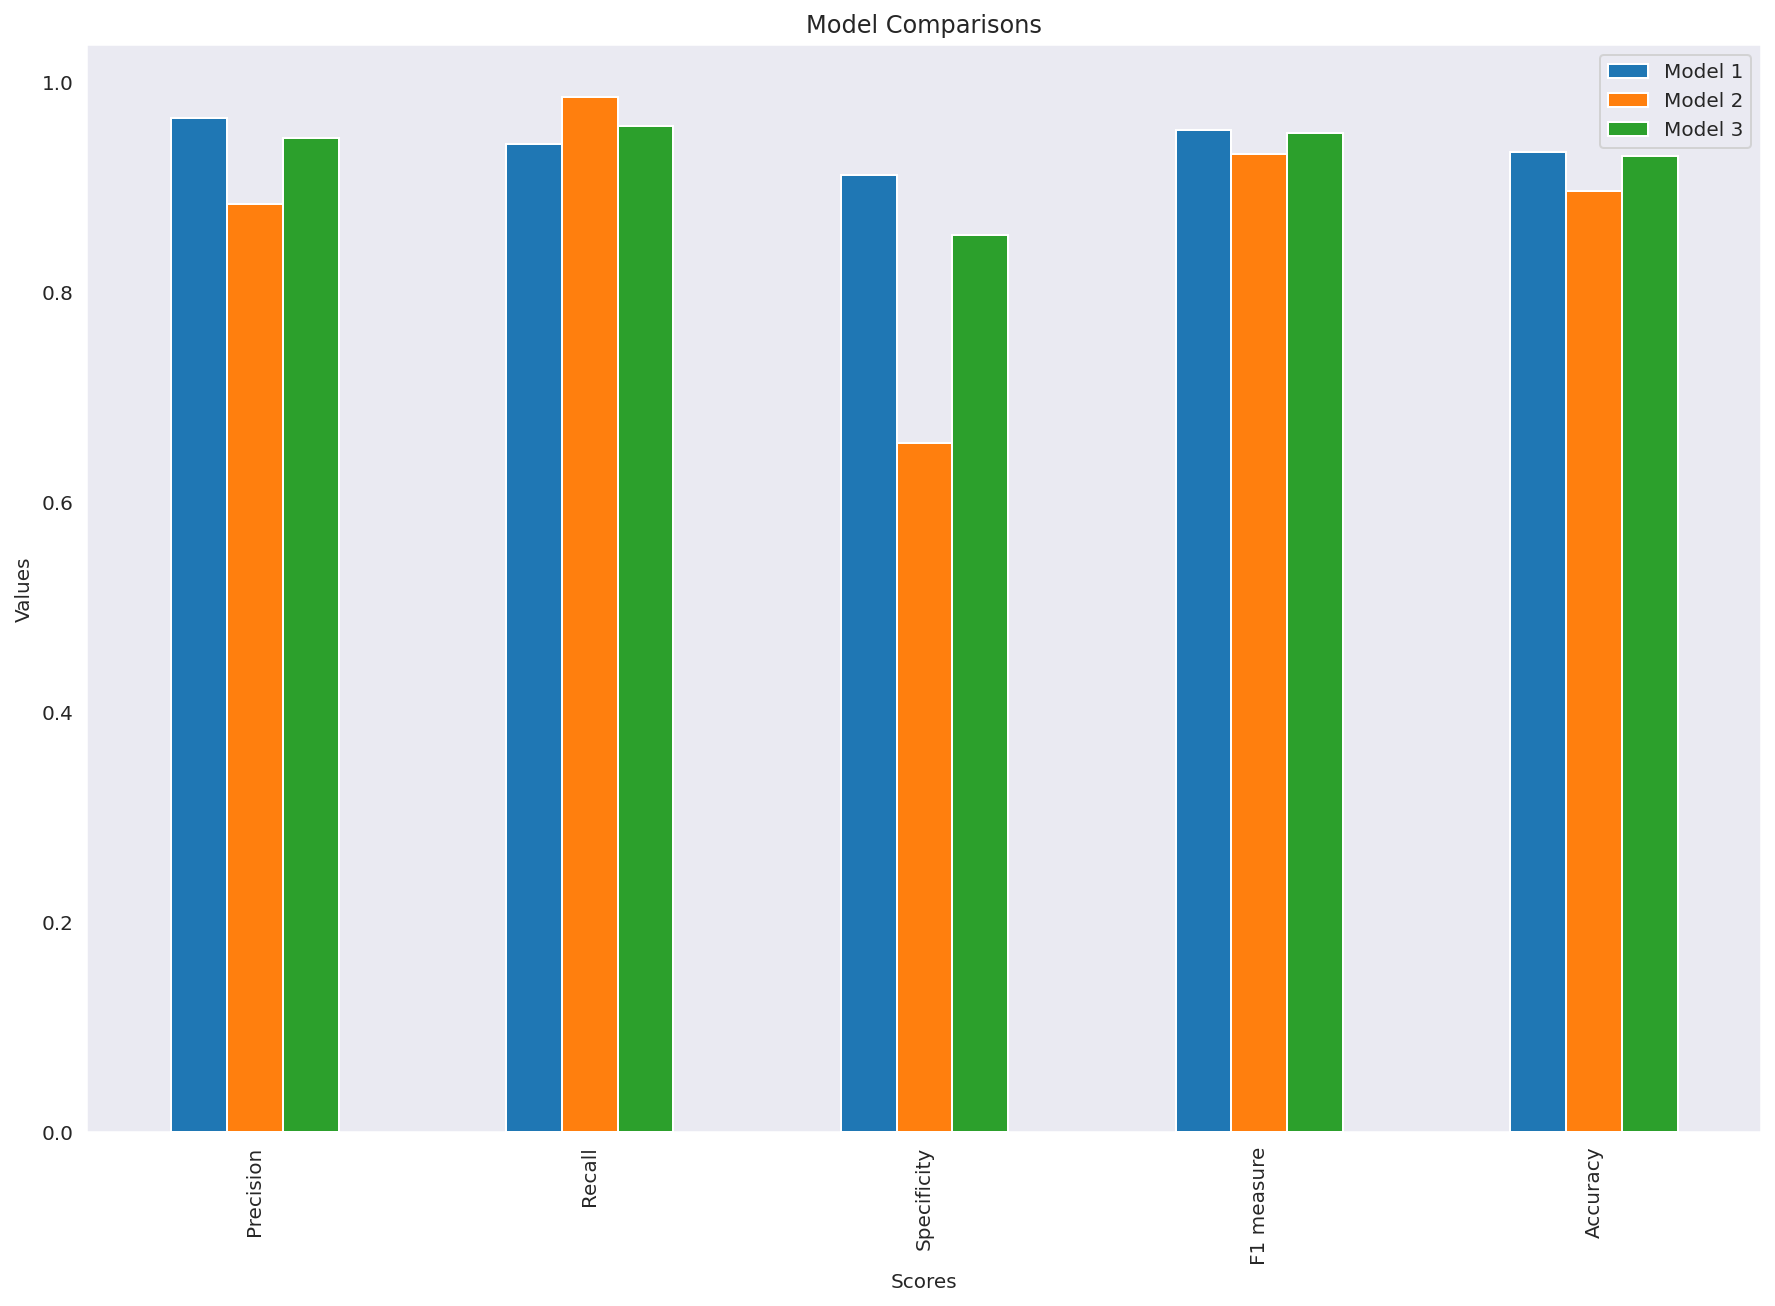

In [ ]:
# Plotting the Results on a Bar Plot

import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

plt.rcParams["figure.figsize"] = [15, 10]
# Set up with a higher resolution screen (useful on Mac)
%config InlineBackend.figure_format = 'retina'

sns.set_style("dark")

plotdata = pd.DataFrame({
    "Model 1":[0.966, 0.941, 0.912, 0.954, 0.933],
    "Model 2":[0.884, 0.986, 0.656, 0.932, 0.896],
    "Model 3":[0.947, 0.958, 0.854, 0.952, 0.930]
    }, 
    index=["Precision", "Recall", "Specificity", "F1 measure", "Accuracy"]
)
plotdata.plot(kind="bar")
plt.title("Model Comparisons", loc='center')
plt.xlabel("Scores")
plt.ylabel("Values")

#**Interpretability through Visualizations**

#Here some Visualizations are applied to interpret how a pre-trained Transfer Learning model is performing. According to this paper **(A Survey on Explainable Artificial Intelligence (XAI): towards Medical XAI, Erico Tjoa, and Cuntai Guan, Fellow, IEEE)** the choice of how to interpret the model is crucial especially in very sensitive settings such as Healthcare. Accordingly some methods are applied to look at how the model layers function and the outcome predictions.

Other References Include:

1) https://medium.com/google-developer-experts/interpreting-deep-learning-models-for-computer-vision-f95683e23c1d

2) https://towardsdatascience.com/visualizing-intermediate-activation-in-convolutional-neural-networks-with-keras-260b36d60d0

3) https://github.com/gabrielpierobon/cnnshapes/blob/master/README.md



#Installing the Necessary Libraries

In [ ]:
from keras.utils.np_utils import to_categorical
from PIL import Image
from IPython.display import display
import numpy as np

# you may want to keep logging enabled when doing your own work
import logging
import tensorflow as tf
tf.get_logger().setLevel(logging.ERROR) # disable Tensorflow warnings for this tutorial
import warnings
warnings.simplefilter("ignore") # disable Keras warnings for this tutorial
import keras

In [ ]:
pip install tf.explain

     |████████████████████████████████| 51kB 2.3MB/s 


In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tf_explain.core.activations import ExtractActivations
from tensorflow.keras.applications.xception import decode_predictions
from tf_explain.core.occlusion_sensitivity import OcclusionSensitivity
from tf_explain.core.smoothgrad import SmoothGrad
from tf_explain.callbacks.grad_cam import GradCAMCallback
from tf_explain.callbacks.smoothgrad import SmoothGradCallback
from tf_explain.callbacks.occlusion_sensitivity import OcclusionSensitivityCallback
from tf_explain.callbacks.activations_visualization import ActivationsVisualizationCallback
from tf_explain.callbacks.integrated_gradients import IntegratedGradientsCallback
from tf_explain.callbacks.gradients_inputs import GradientsInputsCallback
from tf_explain.callbacks.vanilla_gradients import VanillaGradientsCallback

In [ ]:
# we start from a path / URI.
image1 = '/gdrive/MyDrive/Colab Notebooks/output2/test/PNEUMONIA/person28_bacteria_139.jpeg'
image2 = '/gdrive/MyDrive/Colab Notebooks/output2/test/NORMAL/IM-0162-0001.jpeg'

#**Making Image Predictions**

In [ ]:
# we could resize the image manually
# but instead let's use a utility function from `keras.preprocessing`
# we pass the required dimensions as a (height, width) tuple
img = keras.preprocessing.image.load_img(image2, target_size=(224, 224)) # -> PIL image
im = keras.preprocessing.image.img_to_array(img) # -> numpy array
img_tensor = np.expand_dims(im, axis=0)
img_tensor /= 255.

Text(0.5, 1.0, 'NORMAL')

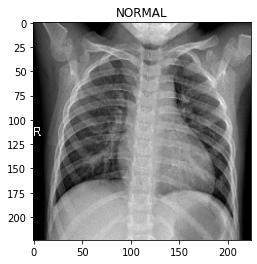

In [ ]:
# Plotting the original Chest X-Ray with it's diagnosis
plt.imshow(img)
plt.title('NORMAL')

Text(0.5, 1.0, 'PNEUMONIA')

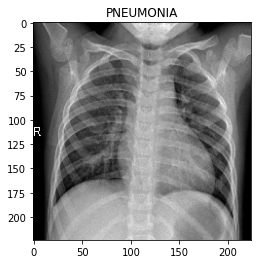

In [ ]:
# Plotting the Model Prediction based to compare to the above Chest X-Ray
plt.imshow(img)
prediction = new_model2.predict_classes(img_tensor)

if prediction == 0:
  class_name = 'NORMAL'
else:
  class_name = 'PNEUMONIA'


plt.title(class_name)

#**Visualization the CNN Layer output for one layer**

In [ ]:
model_new = applications.Xception(weights = "imagenet", include_top=True, input_shape = (299, 299, 3))

In [ ]:
# we could resize the image manually
# but instead let's use a utility function from `keras.preprocessing`
# we pass the required dimensions as a (height, width) tuple
img = keras.preprocessing.image.load_img(image2, target_size=(299, 299)) # -> PIL image
im = keras.preprocessing.image.img_to_array(img) # -> numpy array
img_tensor = np.expand_dims(im, axis=0)
img_tensor /= 255.

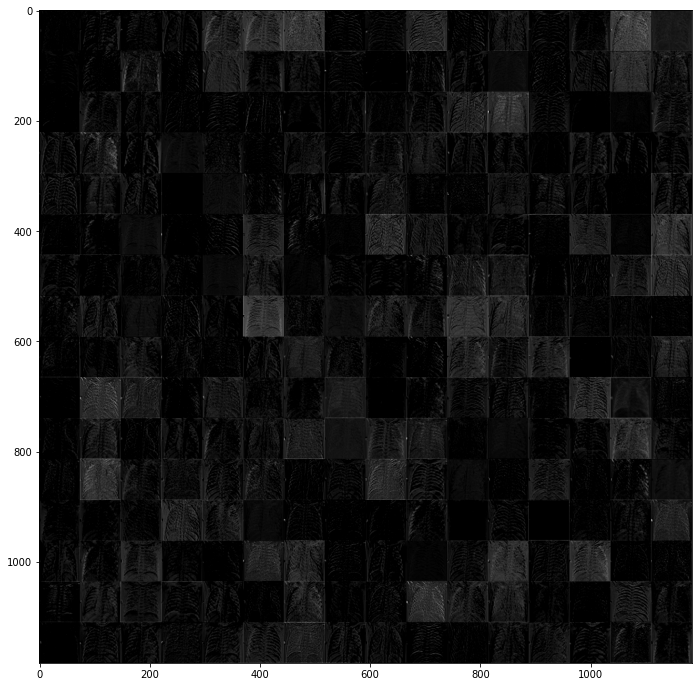

In [ ]:
#Explaining One Layer of the Model
explainer = ExtractActivations()
grid = explainer.explain((np.array([im]), None), model_new, ['block3_sepconv2_act'])
fig, ax = plt.subplots(figsize=(12, 12))
ax.imshow(grid, cmap='binary_r')

#**Visualizing Multiple Layer Outputs**

#Here we are visualizing how each layer of the model works. The model starts with clearer visuals in the input layer then becomes more abstract as we go into the deeper layers. 

#The first layer retains almost the full shape of the Chest X-Ray, some filters though are not activated and are left blank. Most of the information is retained at this stage.

#As we go into the deeper layers, activations become increasingly abstract and less visually interpretable; less information is shown about the visual contents of the image and more is focused on the class of the image, thus focus is more on particular features, those features are what make up the Chest X-Ray class.

#As we look at the layers close to the Output, we start to see again more visuals and less focus on the particular features.

#**Looking at the Deep (Top) Layers' Output**

In [ ]:
layer_outputs = [layer.output for layer in model_new.layers[:25]] 
# Extracts the outputs of the top layers
activation_model = models.Model(inputs=model_new.input, outputs=layer_outputs) # Creates a model that will return these outputs, given the model input

In [ ]:
activations = activation_model.predict(img_tensor) 
# Returns a list of five Numpy arrays: one array per layer activation

In [ ]:
first_layer_activation = activations[0]
print(first_layer_activation.shape)

(1, 299, 299, 3)


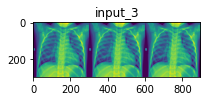

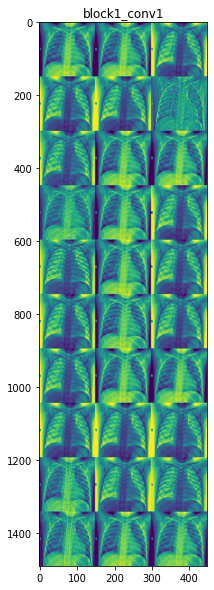

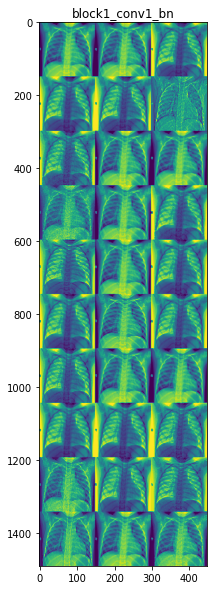

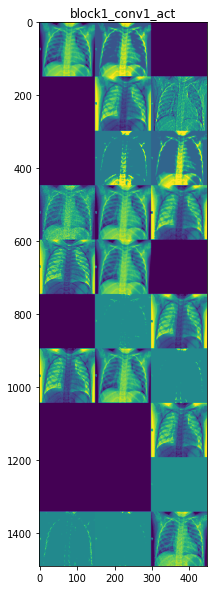

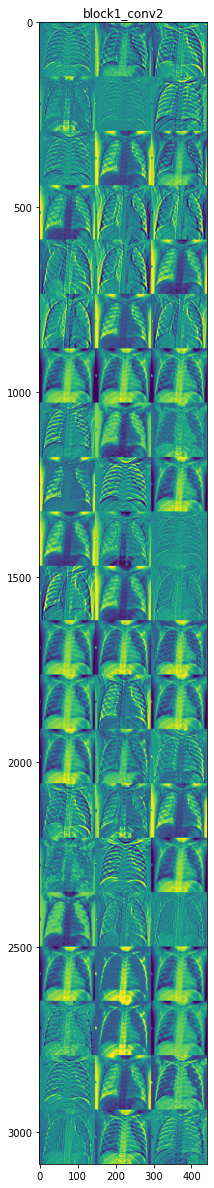

In [ ]:
layer_names = []
for layer in model_new.layers[:5]:
    layer_names.append(layer.name) # Names of the layers, so you can have them as part of your plot
    
images_per_row = 3

for layer_name, layer_activation in zip(layer_names, activations): # Displays the feature maps
    n_features = layer_activation.shape[-1] # Number of features in the feature map
    size = layer_activation.shape[1] #The feature map has shape (1, size, size, n_features).
    n_cols = n_features // images_per_row # Tiles the activation channels in this matrix
    display_grid = np.zeros((size * n_cols, images_per_row * size))
    for col in range(n_cols): # Tiles each filter into a big horizontal grid
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            channel_image -= channel_image.mean() # Post-processes the feature to make it visually palatable
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size, # Displays the grid
                         row * size : (row + 1) * size] = channel_image
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

#**Looking at the Last Few Layers' Output**

In [ ]:
layer_outputs = [layer.output for layer in model_new.layers[:140]] 
# Extracts the outputs of the last layers
activation_model = models.Model(inputs=model_new.input, outputs=layer_outputs) # Creates a model that will return these outputs, given the model input

In [ ]:
activations = activation_model.predict(img_tensor) 
# Returns a list of five Numpy arrays: one array per layer activation

In [ ]:
first_layer_activation = activations[0]
print(first_layer_activation.shape)

(1, 299, 299, 3)


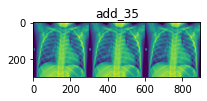

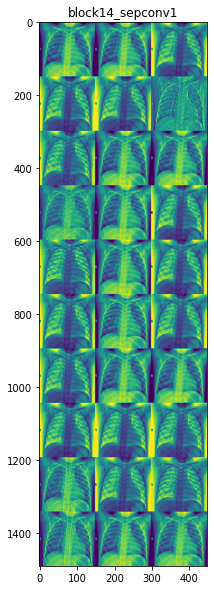

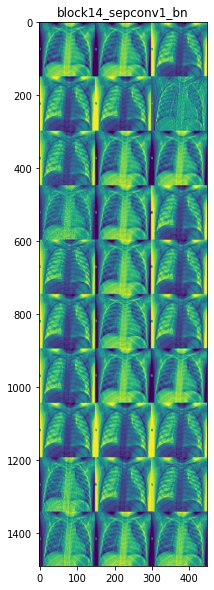

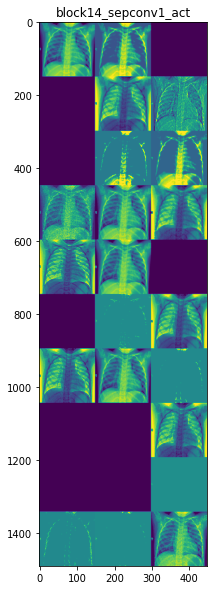

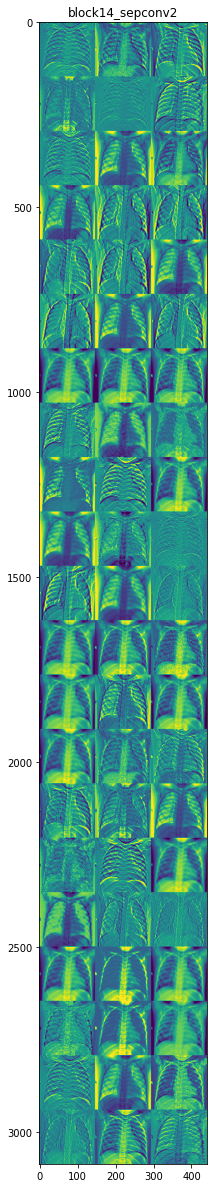

In [ ]:
layer_names = []
for layer in model_new.layers[125:130]:
    layer_names.append(layer.name) # Names of the layers, so you can have them as part of your plot
    
images_per_row = 3

for layer_name, layer_activation in zip(layer_names, activations): # Displays the feature maps
    n_features = layer_activation.shape[-1] # Number of features in the feature map
    size = layer_activation.shape[1] #The feature map has shape (1, size, size, n_features).
    n_cols = n_features // images_per_row # Tiles the activation channels in this matrix
    display_grid = np.zeros((size * n_cols, images_per_row * size))
    for col in range(n_cols): # Tiles each filter into a big horizontal grid
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            channel_image -= channel_image.mean() # Post-processes the feature to make it visually palatable
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size, # Displays the grid
                         row * size : (row + 1) * size] = channel_image
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')